In [1]:
import sys
import cv2
import os
import math
import random
import pickle
import copy
import numpy as np
sys.path.append("C:\\Users\\user\\Documents\\Workspace\\MeronymNet-PyTorch\\src")

In [2]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import DataLoader
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

In [3]:
from losses import BoxVAE_losses as loss
from components.AutoEncoder import GCNAutoEncoder
from components.Decoder import Decoder

In [4]:
import matplotlib.pyplot as plt

In [5]:
from mask_generation import masked_sketch

In [6]:
colors = [(1, 0, 0),
          (0.737, 0.561, 0.561),
          (0.255, 0.412, 0.882),
          (0.545, 0.271, 0.0745),
          (0.98, 0.502, 0.447),
          (0.98, 0.643, 0.376),
          (0.18, 0.545, 0.341),
          (0.502, 0, 0.502),
          (0.627, 0.322, 0.176),
          (0.753, 0.753, 0.753),
          (0.529, 0.808, 0.922),
          (0.416, 0.353, 0.804),
          (0.439, 0.502, 0.565),
          (0.784, 0.302, 0.565),
          (0.867, 0.627, 0.867),
          (0, 1, 0.498),
          (0.275, 0.51, 0.706),
          (0.824, 0.706, 0.549),
          (0, 0.502, 0.502),
          (0.847, 0.749, 0.847),
          (1, 0.388, 0.278),
          (0.251, 0.878, 0.816),
          (0.933, 0.51, 0.933),
          (0.961, 0.871, 0.702)]
colors = (np.asarray(colors)*255)
canvas_size = 660
def plot_bbx(bbx):
    bbx = bbx*canvas_size
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    for i, coord in enumerate(bbx):
        x_minp, y_minp,x_maxp , y_maxp= coord
        if [x_minp, y_minp,x_maxp , y_maxp]!=[0,0,0,0]:
            cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[i], 6)
    return canvas


In [7]:
def inference(decoder, nodes, obj_class, latent_dims, batch_size):

    decoder.cuda()
    z_latent = torch.normal(torch.zeros([batch_size,latent_dims])).cuda()
    nodes = torch.reshape(nodes,(batch_size,decoder.num_nodes))
    obj_class = torch.reshape(obj_class,(batch_size, decoder.class_size))
    conditioned_z = torch.cat([nodes, z_latent],dim=-1)
    conditioned_z = torch.cat([obj_class, conditioned_z],dim=-1)
    
    x_bbx, x_lbl, x_edge, class_pred = decoder(conditioned_z)
        
    return x_bbx, x_lbl, x_edge, class_pred, z_latent

In [8]:
def get_part_label(labels):
    label = 0
    for i in range(len(labels)):
        label+=labels[-i-1]*(2**i)
    return label


In [9]:
def image_grid(test_layout, train_layouts, obj_class):
    """Return a 1X6 grid of the layouts as a matplotlib figure."""
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(20, 10))
    plt.subplot(2, 5, 1, title="Test layout "+str(obj_class))
    plt.imshow(plot_bbx(test_layout), cmap=plt.cm.binary)

    for i in range(min(4, len(train_layouts))):
        # Start next subplot.
        plt.subplot(2, 5, i + 2, title="Train match")
        plt.imshow(plot_bbx(train_layouts[i]), cmap=plt.cm.binary)    
    return figure

def find_k_nearest(data, sample, k):
    
    distances = np.sum(np.square(data - sample), axis=-1)
    k = min(k, len(distances)-1)
    selected_idx = np.argpartition(distances, k)
    
    return selected_idx[:k]

    

In [10]:
outfile = 'D:/meronym_data/X_train_raw.np'
with open(outfile, 'rb') as pickle_file:
    X_train = pickle.load(pickle_file)

outfile = 'D:/meronym_data/class_v_train_raw.np'
with open(outfile, 'rb') as pickle_file:
    class_v = pickle.load(pickle_file)

outfile = 'D:/meronym_data/adj_train_raw.np'
with open(outfile, 'rb') as pickle_file:
    adj_train = pickle.load(pickle_file)

outfile = 'D:/meronym_data/X_test.np'
with open(outfile, 'rb') as pickle_file:
    X_test = pickle.load(pickle_file)

outfile = 'D:/meronym_data/adj_test.np'
with open(outfile, 'rb') as pickle_file:
    adj_test = pickle.load(pickle_file)
    
outfile = 'D:/meronym_data/class_v_test.np'
with open(outfile, 'rb') as pickle_file:
    class_v_test = pickle.load(pickle_file)

In [11]:
X_train[X_train<=0] = 0
X_test[X_test<=0] = 0

X_train[X_train>=1] = 1
X_test[X_test>=1] = 1

In [12]:
random.seed(10)
train_idx = np.random.randint(1,len(X_train),len(X_train))
test_idx = np.random.randint(1,len(X_test),len(X_test))

batch_size = 64

train_list =[]
for idx, batch in enumerate(zip(copy.deepcopy(X_train[train_idx]),
                                copy.deepcopy(class_v[train_idx]),
                                copy.deepcopy(adj_train[train_idx]))):
    edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda().float())
    train_list.append(Data(x = torch.from_numpy(batch[0]).cuda().float(),
                           y = torch.from_numpy(batch[1]).cuda().float(),
                           edge_index = edge_index
                                )
                     )
    batch_train_loader = DataLoader(train_list, batch_size=batch_size)
    
val_list = []
for idx, batch in enumerate(zip(copy.deepcopy(X_test[test_idx]),
                                copy.deepcopy(class_v_test[test_idx]), 
                                copy.deepcopy(adj_test[test_idx]))):
    edge_index, _ = dense_to_sparse(torch.from_numpy(batch[2]).cuda().float())
    val_list.append(Data(x = torch.from_numpy(batch[0]).cuda().float(),
                         y = torch.from_numpy(batch[1]).cuda().float(),
                         edge_index = edge_index
                                )
                     )
batch_val_loader = DataLoader(val_list, batch_size=batch_size)


C:\Users\user\miniconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [13]:
#train encodings
latent_dims = 64
batch_size = 64
num_nodes = 24
bbx_size = 4
num_classes = 10
label_shape = 1
nb_epochs = 200
klw = loss.frange_cycle_linear(nb_epochs)
learning_rate = 0.000062
hidden1 = 32
hidden2 = 16
hidden3 = 128

model_path = ('D:/meronym_data/model/GCN-lr-'
                        +str(learning_rate)
                        +'-batch-'+str(batch_size)
                        +'-h1-'+str(hidden1)
                        +'-h2-'+str(hidden2)
                        +'-h3-'+str(hidden3)+'-test')
summary_path = ('D:/meronym_data/runs/GCN-lr-'
                        +str(learning_rate)
                        +'-batch-'+str(batch_size)
                        +'-h1-'+str(hidden1)
                        +'-h2-'+str(hidden2)
                        +'-h3-'+str(hidden3)+'-test')
write_tensorboard = False
if write_tensorboard:
    writer = SummaryWriter(summary_path)

vae = GCNAutoEncoder(latent_dims,num_nodes,bbx_size,num_classes,label_shape,hidden1, hidden2, hidden3)
vae.load_state_dict(torch.load(model_path+ '/model_weights.pth'))

encoder = vae.encoder
image_shape = [num_nodes, bbx_size]
global_step = 250000
embeddings_mean = []
embeddings_logvar = []
classes = []
node_data = []
labels = []
for i, train_data in enumerate(batch_train_loader, 0):
    
    train_data.cuda()
    node_data_true = train_data.x
    label_true = node_data_true[:,:1]
    class_true = train_data.y
    adj_true = train_data.edge_index
    batch = train_data.batch
    z_mean, z_logvar = encoder(adj_true, node_data_true, class_true)
    embeddings_mean.append(z_mean.detach().to("cpu").numpy())
    embeddings_logvar.append(z_logvar.detach().to("cpu").numpy())
    classes.append(class_true.detach().to("cpu").numpy())
    node_data.append(node_data_true.detach().to("cpu").numpy())
    labels.append(label_true.detach().to("cpu").numpy())

In [14]:
mean_embedding_array = np.concatenate(embeddings_mean)

node_batches = []
label_batches = []
for label, node in zip(labels, node_data):
    node_batches.append(np.reshape(node,(int(len(node)/24),24,5)))
    label_batches.append(np.reshape(label,(int(len(label)/24), 24)))
all_node_data = np.concatenate(node_batches, axis=0)
all_labels = np.concatenate(label_batches, axis=0)
batches = []
for batch in classes:
    batches.append(np.reshape(batch,(int(len(batch)/10),10)))
class_labels = np.concatenate(batches, axis=0)
class_labels = np.argmax(class_labels, axis=1)
print(mean_embedding_array.shape)
print(all_node_data.shape)
print(all_labels.shape)
print(class_labels.shape)
part_labels = np.apply_along_axis(get_part_label, 1, all_labels)


(2679, 64)
(2679, 24, 5)
(2679, 24)
(2679,)


In [15]:
part_labels

array([16253184., 14025216., 13956064., ..., 12388352., 12257280.,
        8484342.])

In [16]:
decoder = vae.decoder
image_shape = [num_nodes, bbx_size]
global_step = 250000
test_pred_boxes = []
test_classes = []
test_labels = []
samples_latent_states = []
for i, val_data in enumerate(batch_val_loader, 0):
    
    val_data.cuda()
    node_data_true = val_data.x
    label_true = node_data_true[:,:1]
    class_true = val_data.y
    val_batch_size = int(class_true.shape[0]/10)
    output = inference(decoder, label_true , class_true, latent_dims, val_batch_size)
    node_data_pred_test, _, _, _, sampled_latent = output
    test_pred_boxes.append((node_data_pred_test*label_true.reshape([int(label_true.shape[0]/24),24,1])).detach().to("cpu").numpy())
    test_classes.append(class_true.detach().to("cpu").numpy())
    test_labels.append(label_true.detach().to("cpu").numpy())    
    samples_latent_states.append(sampled_latent.detach().to("cpu").numpy())

test_embedding_array = np.concatenate(samples_latent_states)

node_batches = []
label_batches = []
test_node_data = np.concatenate(test_pred_boxes, axis=0)
batches = []
for batch in test_classes:
    batches.append(np.reshape(batch,(int(len(batch)/10),10)))
test_classes = np.concatenate(batches, axis=0)
test_classes = np.argmax(test_classes, axis=1)
label_batches = []

for label in test_labels:
    label_batches.append(np.reshape(label,(int(len(label)/24), 24)))
all_test_labels = np.concatenate(label_batches, axis=0)
test_part_labels = np.apply_along_axis(get_part_label, 1, all_test_labels)

print(test_embedding_array.shape)
print(test_node_data.shape)
print(test_classes.shape)
print(test_part_labels.shape)

C:\Users\user\Documents\Workspace\MeronymNet-PyTorch\src\components\Decoder.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_pred = self.act2(self.dense_cls(x))


(16350, 64)
(16350, 24, 4)
(16350,)
(16350,)


[]
[]
[]
[]
[1573 2405 2053  434   17 2144 1261 1020  250 2021]
[]
[]
[]
[]
[ 502 1900   16 1630 2669 2064 1290  811 2416  522]


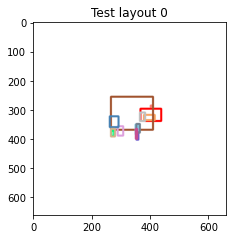

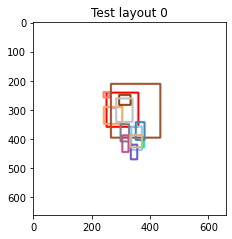

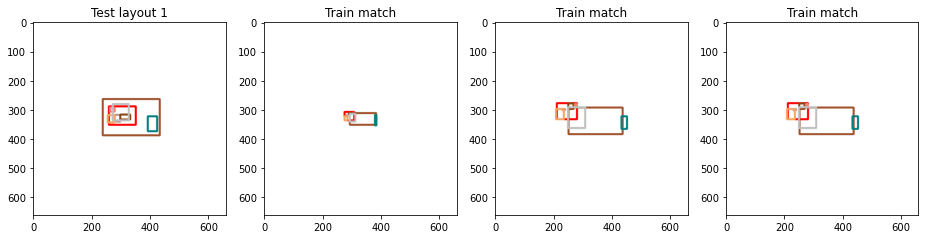

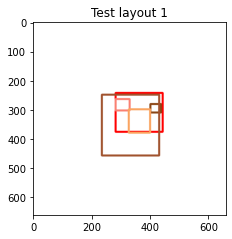

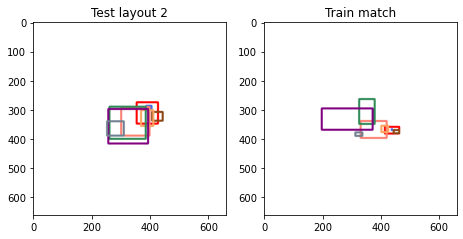

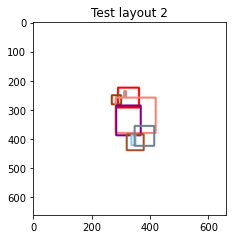

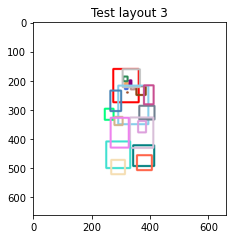

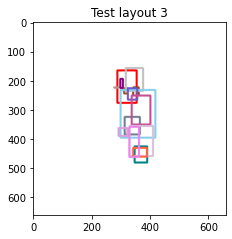

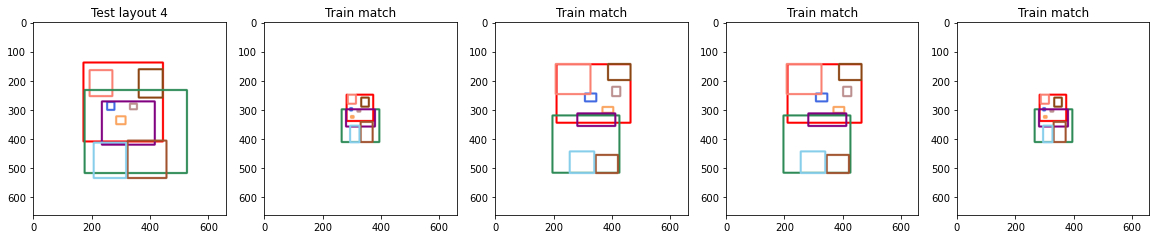

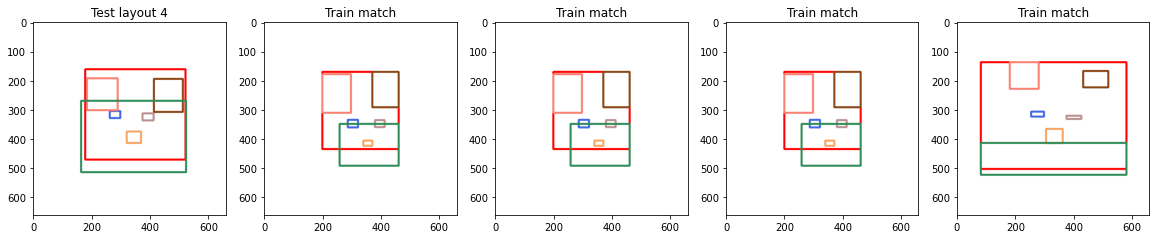

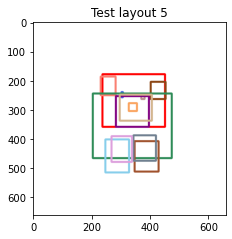

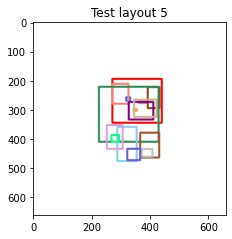

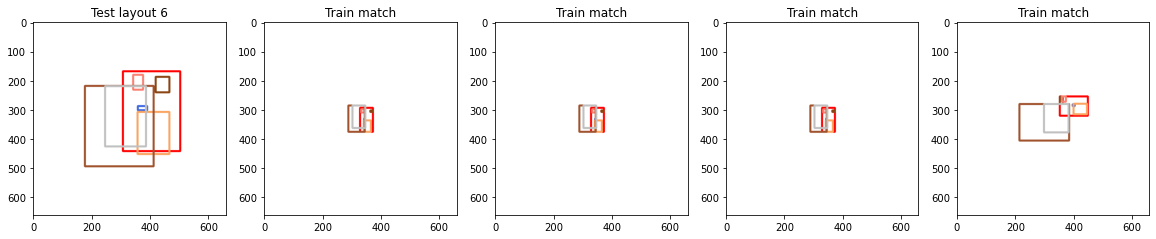

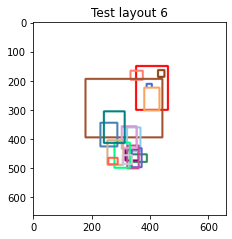

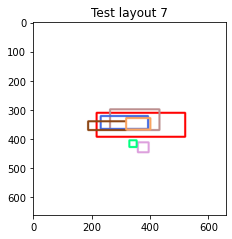

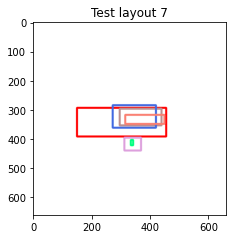

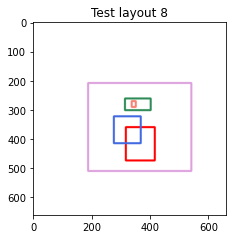

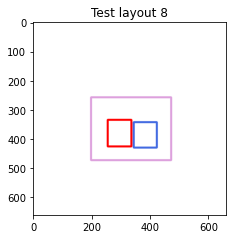

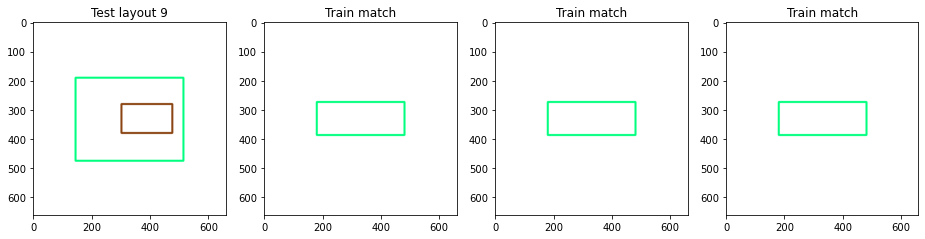

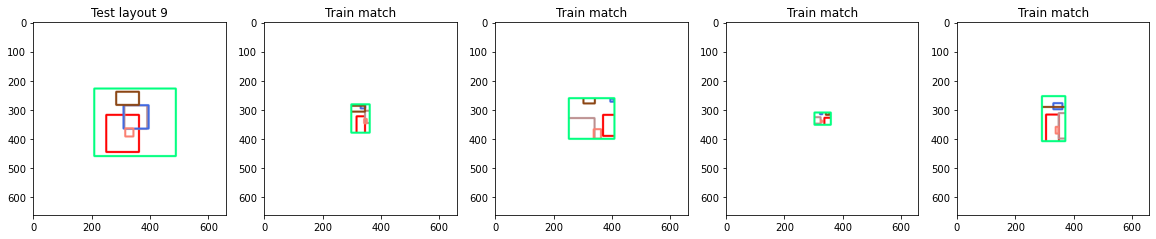

In [17]:
for obj_class in range(10):
    test_subset = np.where(test_classes==obj_class)[0]
    if len(test_subset)>0:
        test_idx = random.choice(test_subset)
        test_boxes = test_node_data[test_idx]
        test_class = test_classes[test_idx]
        test_embedding = test_embedding_array[test_idx]
        subset_idx = np.where((class_labels==obj_class) & (part_labels==test_part_labels[test_idx]))[0]
        
        nearest = find_k_nearest(mean_embedding_array[subset_idx], test_embedding, 4)
        train_layouts = all_node_data[subset_idx[nearest], :, 1:]
        img = image_grid(test_boxes, train_layouts, obj_class, )

        test_idx = random.choice(test_subset)
        test_boxes = test_node_data[test_idx]
        test_class = test_classes[test_idx]
        test_embedding = test_embedding_array[test_idx]
        subset_idx = np.where((class_labels==obj_class) & (part_labels==test_part_labels[test_idx]))[0]
        
        nearest = find_k_nearest(mean_embedding_array[subset_idx], test_embedding, 10)
        train_layouts = all_node_data[subset_idx[nearest], :, 1:]
        print(subset_idx[nearest])
        img = image_grid(test_boxes, train_layouts, obj_class)